In [58]:
print('What\'s up?')

What's up?


# Notebook Imports

In [59]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [60]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data-s.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data-s.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

# Reading Files

In [61]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [62]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [63]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)




Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [64]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [65]:
for i in generate_squares(5):
    print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

## Email body extraction

In [66]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body


In [67]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [68]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

,MESSAGE,CATEGORY
00260.c75ce8b8d8bfc55723426979d260bf61,This is a Multipart MIME message. Since your m...,1
00242.e030c8b1f053037aeffb062f3a34b523,\n\nDear Sir or Madam\n\n\n\nIn the past you h...,1
00267.ef433fb350170f28a1567cbc24900e53,ATTN:\n\n\n\nI am Edward Mulete JR. the son of...,1
00496.1a37de098f6c8847c3c7839d73cc7106,<html>\n\n<head>\n\n<title>Toy</title>\n\n</he...,1
00031.a78bb452b3a7376202b5e62a81530449,"Suppliers of Computers, Printers, etc. & Consu...",1


In [69]:
spam_emails.shape

(1898, 2)

In [70]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

In [71]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00260.c75ce8b8d8bfc55723426979d260bf61,This is a Multipart MIME message. Since your m...,1
00242.e030c8b1f053037aeffb062f3a34b523,\n\nDear Sir or Madam\n\n\n\nIn the past you h...,1
00267.ef433fb350170f28a1567cbc24900e53,ATTN:\n\n\n\nI am Edward Mulete JR. the son of...,1
00496.1a37de098f6c8847c3c7839d73cc7106,<html>\n\n<head>\n\n<title>Toy</title>\n\n</he...,1
00031.a78bb452b3a7376202b5e62a81530449,"Suppliers of Computers, Printers, etc. & Consu...",1


In [72]:
data.tail()

,MESSAGE,CATEGORY
01299.21bf6f0946fe21adc3e99db3e541ee57,Marc Perkel wrote:\n\n> But - MY POINT IS - ca...,0
01336.03d61f76f58b98d6c4c0f4f303994db4,Update of /cvsroot/spamassassin/spamassassin/l...,0
00490.9c5dd006a16b1e30c9162ba4b4b75ea8,"As list administrator, your authorization is r...",0
00231.8096ae53e70b1b72b5935b12b823597b,Ciaran Mac Lochlainn stated the following:\n\n...,0
00030.cc523265aefc37ee6ce3015d8ff6aa24,"Hi, \n\nI'm looking to build a completely sile...",0


# Data Cleaning: Checking for Missing Values

In [73]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [74]:
type("")

str

In [75]:
len("")

0

In [76]:
my_var = None

In [77]:
type(my_var)

NoneType

In [78]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [79]:
(data.MESSAGE.str.len() == 0).sum()

3

In [80]:
# Challenge: how would you check the number of entries with null/None values?
data.MESSAGE.isnull().sum()

0

### Locate empty emails

In [81]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [82]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [83]:
data[4608:4611]

,MESSAGE,CATEGORY
00470.31854a1dce26d60c524ac8051bd00068,"On Tue, Aug 20, 2002 at 12:06:18PM +0100, Phil...",0
01012.235d771c2e3094e4b4310a86ac7e7352,-----BEGIN PGP SIGNED MESSAGE-----\n\nHash: SH...,0
00753.373de9a53cc7e59ebf91f4e27099799b,Interesting project involving geospatial data ...,0


# Remove System File Entries from Dataframe

# Add Document IDs to Track Emails in Dataset

In [84]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [85]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,This is a Multipart MIME message. Since your m...,1,00260.c75ce8b8d8bfc55723426979d260bf61
1,\n\nDear Sir or Madam\n\n\n\nIn the past you h...,1,00242.e030c8b1f053037aeffb062f3a34b523
2,ATTN:\n\n\n\nI am Edward Mulete JR. the son of...,1,00267.ef433fb350170f28a1567cbc24900e53
3,<html>\n\n<head>\n\n<title>Toy</title>\n\n</he...,1,00496.1a37de098f6c8847c3c7839d73cc7106
4,"Suppliers of Computers, Printers, etc. & Consu...",1,00031.a78bb452b3a7376202b5e62a81530449


In [86]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5794,Marc Perkel wrote:\n\n> But - MY POINT IS - ca...,0,01299.21bf6f0946fe21adc3e99db3e541ee57
5795,Update of /cvsroot/spamassassin/spamassassin/l...,0,01336.03d61f76f58b98d6c4c0f4f303994db4
5796,"As list administrator, your authorization is r...",0,00490.9c5dd006a16b1e30c9162ba4b4b75ea8
5797,Ciaran Mac Lochlainn stated the following:\n\n...,0,00231.8096ae53e70b1b72b5935b12b823597b
5798,"Hi, \n\nI'm looking to build a completely sile...",0,00030.cc523265aefc37ee6ce3015d8ff6aa24


# Save to File using Pandas

In [87]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [88]:
data.CATEGORY.value_counts()

0    3901
1    1898
Name: CATEGORY, dtype: int64

In [89]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

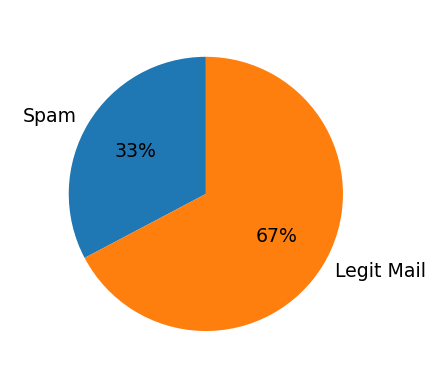

In [90]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%')
plt.show()

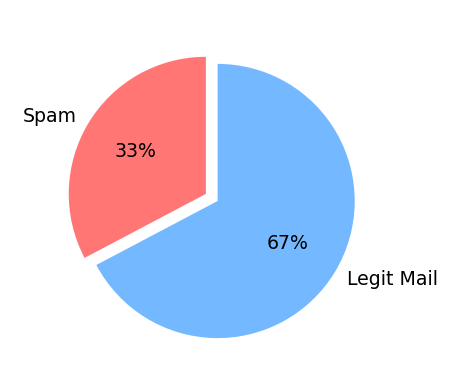

In [91]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.1])
plt.show()

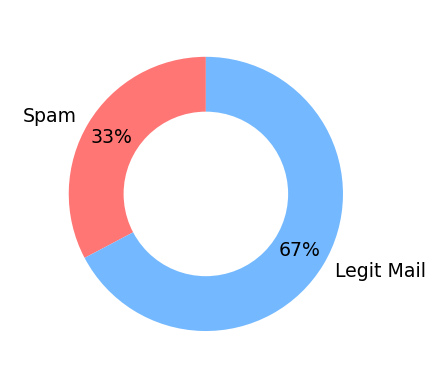

In [92]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

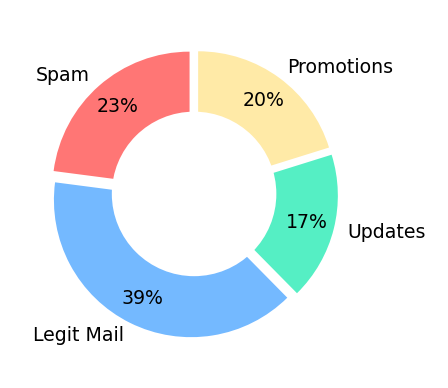

In [93]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colours = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8, explode=offset)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

### Text Pre-Processing

In [94]:
# convert to lower case
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [95]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/gian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [96]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/gian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [97]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to /home/gian/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to /home/gian/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenising

In [98]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words 

In [99]:
stop_words = set(stopwords.words('english'))

In [100]:
type(stop_words)

set

In [101]:
if 'this' in stop_words: print('Found it!')

Found it!


In [102]:
# Challenge: print out 'Nope. Not in here' if the word "hello" is not contained in stop_words

In [103]:
if 'hello' not in stop_words: print('Nope. Not in here')

Nope. Not in here


In [104]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Word Stems and Stemming

In [105]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
      Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')


filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Removing Punctuation

In [106]:
'p'.isalpha()

True

In [107]:
'?'.isalpha()

False

In [108]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. ??? \
      Nobody expects the Spanish Inquisition!'

words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english')
filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags from Emails

In [109]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

ATTN:



I am Edward Mulete JR. the son of Mr. 



STEVE MBEKI MULETE from Zimbabwe. I am sorry this mail

Will surprise you, though we do not know, my mother Mrs. Clara 

Got your contact through her private search.

Due to the current war against white farmers in

Zimbabwe and the support of President Robert Mugabe to

Claim all white owned farms in our country to gain

Favor for re-election.



All white farmers were asked to

Surrender their farms to the government for

Re-distribution and infact to his political party

Members and my father though black was the treasury

of the farmers association and a strong member of an

Opposition party that did not support the president

Idea. He then ordered his party members and the police

Under his pay row to invade my father's farm and burn

Down everything in the farm. They killed my

Father and took away a lot of items from his farm.

After the death of my father, our local pastor and a

Close friend of my father handed us over will

D

In [110]:
soup.get_text()

"ATTN:\n\n\n\nI am Edward Mulete JR. the son of Mr. \n\n\n\nSTEVE MBEKI MULETE from Zimbabwe. I am sorry this mail\n\nWill surprise you, though we do not know, my mother Mrs. Clara \n\nGot your contact through her private search.\n\nDue to the current war against white farmers in\n\nZimbabwe and the support of President Robert Mugabe to\n\nClaim all white owned farms in our country to gain\n\nFavor for re-election.\n\n\n\nAll white farmers were asked to\n\nSurrender their farms to the government for\n\nRe-distribution and infact to his political party\n\nMembers and my father though black was the treasury\n\nof the farmers association and a strong member of an\n\nOpposition party that did not support the president\n\nIdea. He then ordered his party members and the police\n\nUnder his pay row to invade my father's farm and burn\n\nDown everything in the farm. They killed my\n\nFather and took away a lot of items from his farm.\n\nAfter the death of my father, our local pastor and a\n\nC

## Functions for Email Processing

In [111]:
def clean_message(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [112]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [113]:
# Challenge: Modify function to remove HTML tags. Then test on Email with DOC_ID 2. 
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
#             filtered_words.append(word) 
    
    return filtered_words

In [114]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['attn',
 'edward',
 'mulet',
 'son',
 'steve',
 'mbeki',
 'mulet',
 'zimbabw',
 'sorri',
 'mail',
 'surpris',
 'though',
 'know',
 'mother',
 'clara',
 'got',
 'contact',
 'privat',
 'search',
 'due',
 'current',
 'war',
 'white',
 'farmer',
 'zimbabw',
 'support',
 'presid',
 'robert',
 'mugab',
 'claim',
 'white',
 'own',
 'farm',
 'countri',
 'gain',
 'favor',
 'white',
 'farmer',
 'ask',
 'surrend',
 'farm',
 'govern',
 'infact',
 'polit',
 'parti',
 'member',
 'father',
 'though',
 'black',
 'treasuri',
 'farmer',
 'associ',
 'strong',
 'member',
 'opposit',
 'parti',
 'support',
 'presid',
 'idea',
 'order',
 'parti',
 'member',
 'polic',
 'pay',
 'row',
 'invad',
 'father',
 'farm',
 'burn',
 'everyth',
 'farm',
 'kill',
 'father',
 'took',
 'away',
 'lot',
 'item',
 'farm',
 'death',
 'father',
 'local',
 'pastor',
 'close',
 'friend',
 'father',
 'hand',
 'us',
 'document',
 'instruct',
 'father',
 'leav',
 'zimbabw',
 'incas',
 'anyth',
 'happen',
 'document',
 'certif',
 'd

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [115]:
data.iat[2, 2]

'00267.ef433fb350170f28a1567cbc24900e53'

In [116]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,IMPORTANT DOMAIN INFORMATION:\n\n\n\n\n\nThe n...,1,00452.ed43fc952c31c82aa29646edfbecb03f
6,<html>\n\n<head>\n\n</head>\n\n<center>\n\n<h1...,1,00476.af3a29817853a5c56bae5257c2d4b742
7,This is a multi-part message in MIME format.\n...,1,00311.9797029f3ee441b00f3b7521e573cb96
8,Dear Sir / Madam\n\n\n\nIf you are fed up of b...,1,00073.8dcd40346d48c69a9e075e935395e96d
9,ATTN:\n\n\n\nI am Bulawa Mulete JR. the son of...,1,00220.cf7d03e161582887dc589229e2896e26
10,++++++++++++++++++++++++++++++++++++++++++++++...,1,00367.9688cdee9dfe720c297672c8f60d998f


In [117]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [118]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]
        
len(flat_list)

412

In [119]:
flat_list

['multipart',
 'mime',
 'messag',
 'sinc',
 'mail',
 'reader',
 'understand',
 'format',
 'messag',
 'may',
 'legibl',
 'sucht',
 'pornodarstel',
 'wenn',
 'du',
 'spaß',
 'sex',
 'hast',
 'und',
 'nebenbei',
 'geld',
 'verdienen',
 'willst',
 'bewirb',
 'auch',
 'du',
 'dich',
 'wir',
 'suchen',
 'natürlich',
 'frauen',
 'und',
 'männer',
 'jeden',
 'alter',
 'mollig',
 'kein',
 'problem',
 'info',
 'unter',
 'au',
 'österreich',
 'au',
 'deutschland',
 'hier',
 'ein',
 'bild',
 'au',
 'einer',
 'produkt',
 'da',
 'vorstellungsvideo',
 'siehst',
 'du',
 'unter',
 'http',
 'solltest',
 'du',
 'unserem',
 'newslett',
 'kein',
 'interess',
 'mehr',
 'haben',
 'dann',
 'trage',
 'dich',
 'bitt',
 'au',
 'unter',
 'http',
 'attach',
 'agamaaaagaaaabibawabaaaaaqaaabobbqabaaaajaaaabsbbqabaaaalaaaacgbawabaaaa',
 'agauaaaapgeaaagrbwaeaaaaaqidaakrbqabaaaaugeaaasscgabaaaawgeaaawsbqabaaaa',
 'aqaaaayaaaapaqiabqaaahycaaaqaqiadaaaahwcaaasaqmaaqaaaaeaaacgkguaaqaaaigc',
 'aqebaqebaaaaaaaaaqidbaugbwgj

In [120]:
%%time

# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

/home/gian/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 27.3 s, sys: 0 ns, total: 27.3 s
Wall time: 27.3 s


In [121]:
nested_list.tail()

DOC_ID
5794    [marc, perkel, wrote, point, catch, phrase, ad...
5795    [updat, directori, modifi, file, tag, log, mes...
5796    [list, administr, author, request, follow, mai...
5797    [ciaran, mac, lochlainn, state, follow, solocd...
5798    [hi, look, build, complet, silent, pc, gon, na...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [122]:
data[data.CATEGORY == 1].shape

(1898, 3)

In [123]:
data[data.CATEGORY == 1].tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
1893,Protect Yourself.\n\n\n\nPurchase An Extended ...,1,01378.73df5252cb71f89c885ad49b6ae5fa82
1894,<HTML><HEAD><TITLE>MILFhunter</TITLE>\n\n<META...,1,01334.24b7f4702e0da7e9d7a5f4d284adfc96
1895,"<META HTTP-EQUIV=3D""Content-Type"" CONTENT=3D""t...",1,00322.9c67ae5dc3348e9a0b9a61a408c3f44e
1896,SPECIAL SITUATION ALERTS HOT PICK OF THE YEAR\...,1,00488.e88c2c87a3b72ab47b6420b61279242e
1897,"<html>\n\n<script>open(""http://www.cn1688.net/...",1,00246.d314e68151f961425104dbe6a4e3bc9a


In [124]:
# Challenge: create two variables (doc_ids_spam, doc_ids_ham) which 
# hold onto the indices for the spam and the non-spam emails respectively. 

In [125]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [126]:
doc_ids_ham

Int64Index([1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907,
            ...
            5789, 5790, 5791, 5792, 5793, 5794, 5795, 5796, 5797, 5798],
           dtype='int64', name='DOC_ID', length=3901)

### Subsetting a Series with an Index

In [127]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [128]:
type(nested_list)

pandas.core.series.Series

In [129]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [130]:
nested_list_ham.shape

(3901,)

In [131]:
nested_list_ham.tail()

DOC_ID
5794    [marc, perkel, wrote, point, catch, phrase, ad...
5795    [updat, directori, modifi, file, tag, log, mes...
5796    [list, administr, author, request, follow, mai...
5797    [ciaran, mac, lochlainn, state, follow, solocd...
5798    [hi, look, build, complet, silent, pc, gon, na...
Name: MESSAGE, dtype: object

In [132]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [133]:
# Challenge: use python list comprehension and then find the total number of 
# words in our cleaned dataset of spam email bodies. Also find the total number of 
# words in normal emails in the dataset. Then find the 10 most common words used in 
# spam. Also, find the 10 most common words used in non-spam messages. 

In [134]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

20815

In [135]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [136]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in the spam messages

13242

In [137]:
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

# Creating a Word Cloud

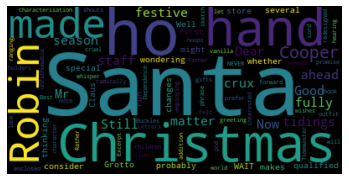

In [138]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [139]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [140]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [141]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [142]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

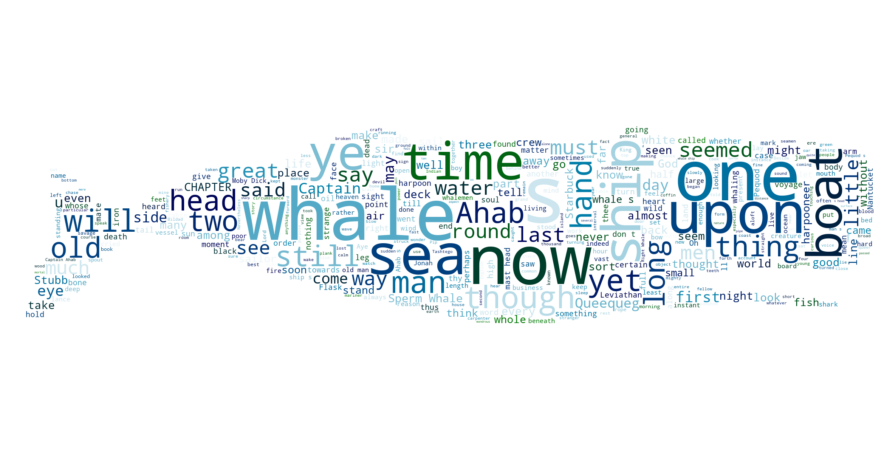

In [143]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=400, colormap='ocean')

word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [144]:
rgb_array.shape

(1024, 2048, 3)

In [145]:
rgb_array[1023, 2047]

array([255, 255, 255], dtype=uint8)

In [146]:
rgb_array[500, 1000]

array([0, 0, 0], dtype=uint8)

In [147]:
# Challenge: use the skull image in the lesson resources to create a word cloud
# for Shakespeare's play Hamlet

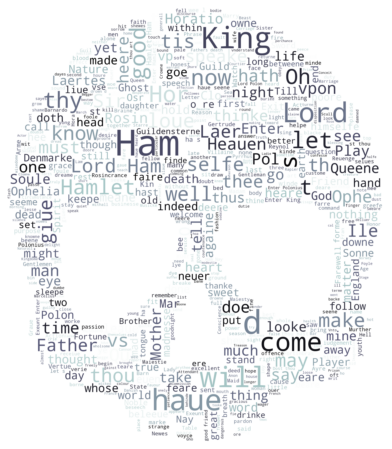

In [148]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255, 255, 255))
image_mask.paste(skull_icon, box=skull_icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      colormap='bone', max_words=600)

word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Cloud of Ham and Spam Messages

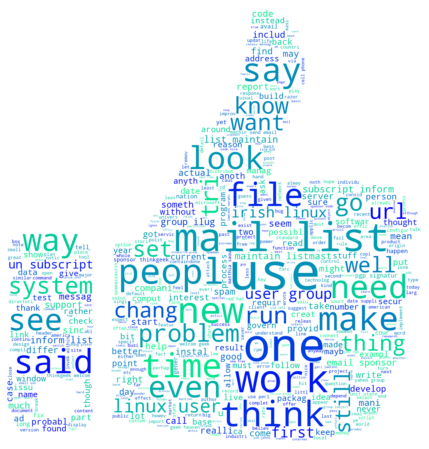

In [149]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=500, colormap='winter')

word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [150]:
# Challenge: Look at the word cloud documentation. Use the custom font included in the 
# lesson resources instead of the default font and create a word cloud of the spammy words

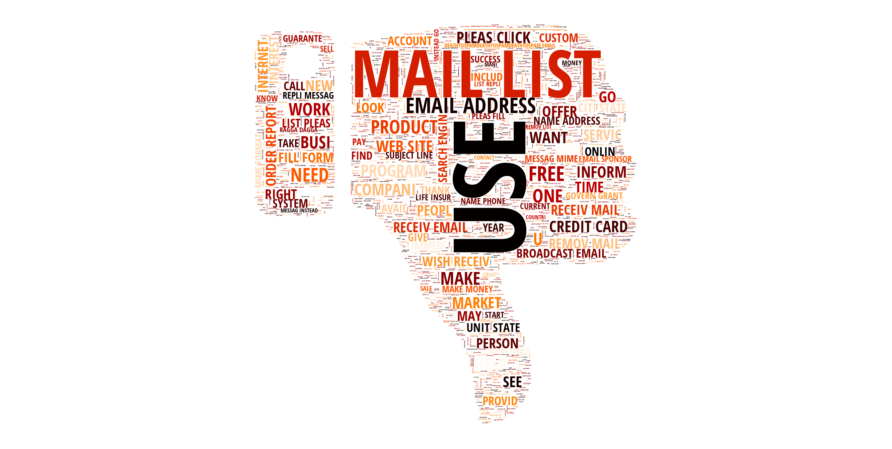

In [151]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=300,
                      max_words=2000, colormap='gist_heat', font_path=CUSTOM_FONT_FILE)

word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [152]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

/home/gian/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [153]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [154]:
# Challenge: Create subset of the series called 'frequent_words' that only contains
# the most common 2,500 words out of the total. Print out the top 10 words

In [155]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


## Create Vocabulary DataFrame with a WORD_ID

In [156]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [157]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Exercise: Checking if a Word is Part of the Vocabulary

In [158]:
# Challenge: Write a line of code that checks if a particular word is part 
# of the vocabulary. Your code should return True if the word is among the 
# 2,500 words that comprise the vocabulary, and False otherwise. Check these words:
# 'machine'
# 'learning'
# 'fun'
# 'learn'
# 'data'
# 'science'
# 'app'
# 'brewery'

In [159]:
any(vocab.VOCAB_WORD == 'machine') # inefficient

False

In [160]:
'brew' in set(vocab.VOCAB_WORD) # better way

False

# Exercise: Find the Email with the Most Number of Words

In [161]:
# Challenge: Print out the number of words in the longest email (after cleaning & stemming).
# Note the longest email's position in the list of cleaned emails. Print out the stemmed
# list of words in the longest email. Print out the longest email from the data dataframe.

# Hint: use the len() function and practice list comprehension

In [162]:
# For loop
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

In [163]:
# Python List Comprehension
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email:', max(clean_email_lengths))


Nr words in the longest email: 7671


In [164]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))


Email position in the list (and the data dataframe) 4684


In [165]:
stemmed_nested_list[np.argmax(clean_email_lengths)]


['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [166]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']


'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix

### Creating a DataFrame with one Word per Column

In [167]:
type(stemmed_nested_list)

pandas.core.series.Series

In [168]:
type(stemmed_nested_list.tolist())

list

In [169]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,multipart,mime,messag,sinc,mail,reader,understand,format,messag,may,...,None,None,None,None,None,None,None,None,None,None
1,dear,sir,madam,past,request,inform,discount,product,hope,find,...,None,None,None,None,None,None,None,None,None,None
2,attn,edward,mulet,son,steve,mbeki,mulet,zimbabw,sorri,mail,...,None,None,None,None,None,None,None,None,None,None
3,toy,abc,good,morn,america,rank,christma,toy,n,new,...,None,None,None,None,None,None,None,None,None,None
4,supplier,comput,printer,etc,consum,central,data,suppli,middleton,road,...,None,None,None,None,None,None,None,None,None,None


In [170]:
word_columns_df.shape

(5799, 7671)

### Splitting the Data into a Training and Testing Dataset

In [171]:
# Challenge: Can you split the data into a training and testing set? Set the test size at 30%. 
# The training data should include 4057 emails. Use a seed value of 42 to shuffle the data. 
# What should the target values be? 

In [172]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                   test_size=0.3, random_state=42)

In [173]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4059
Fraction of training set 0.6999482669425763


In [174]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4100,actual,thought,kind,activ,chat,aol,think,bring,ad,base,...,None,None,None,None,None,None,None,None,None,None
5233,friday,august,gregori,mcrandal,ext,wrote,hi,instal,quak,onto,...,None,None,None,None,None,None,None,None,None,None
5072,funni,load,messag,moo,moo,moo,moo,moo,moo,moo,...,None,None,None,None,None,None,None,None,None,None
1293,overwhelm,debt,high,interest,rate,receiv,annoy,call,creditor,soon,...,None,None,None,None,None,None,None,None,None,None
4357,septemb,guido,van,rossum,said,packag,perhap,use,barri,trick,...,None,None,None,None,None,None,None,None,None,None


In [175]:
y_train.head()


DOC_ID
4100    0
5233    0
5072    0
1293    1
4357    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [176]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [177]:
word_index.get_loc('thu')

392

In [178]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [179]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 8min 31s, sys: 356 ms, total: 8min 31s
Wall time: 8min 32s


In [180]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4100,1,173
1,0,4100,1,417
2,0,4100,1,416
3,0,4100,1,506
4,0,4100,1,2070


In [181]:
sparse_train_df.shape

(445901, 4)

In [182]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
445896,1,860,1,41
445897,1,860,1,21
445898,1,860,1,324
445899,1,860,1,163
445900,1,860,1,57


### Combine Occurrences with the Pandas groupby() Method

In [183]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      0       1              2
       5       1              1
       10      1              2
       47      1              1
       75      1              1

In [184]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [185]:
data.MESSAGE[0]

'This is a Multipart MIME message. Since your mail reader\n\ndoes not understand this format, some or all of\n\nthis message may not be legible.\n\n\n\n--XX9ADB9A99-1A5B9ADBXX\n\nContent-Type: text/plain;\n\n\tcharset=iso-8859-1\n\nContent-Transfer-Encoding: 7bit\n\n\n\nK1-Erotikverlag sucht Pornodarsteller.\n\nWenn Du Spaß am Sex hast und nebenbei Geld verdienen willst, bewirb auch Du Dich. \n\nWir suchen natürliche Frauen und Männer, jeden Alters. Mollig - kein Problem.\n\nInfos unter: 0930 830 13 22 aus Österreich\n\n\n\n01 90 87 43 54 aus Deutschland\n\n1,86 Eu/Min.K1-Callcenter\n\n\n\nHier ein Bild aus einer Produktion.\n\nDas Vorstellungsvideo siehst Du unter:\n\nhttp://www.k1-web.com/Darsteller/index.php\n\n\n\nSolltest Du an unserem Newsletter kein Interesse\n\nmehr haben, dann trage Dich bitte aus unter:\n\nhttp://www.k1-web.com/newsletr.php\n\n\n\n--XX9ADB9A99-1A5B9ADBXX\n\nContent-Type: image/jpeg\n\nContent-Transfer-Encoding: base64\n\nContent-Disposition: attachment; filen

In [186]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,1,2
1,0,5,1,1
2,0,10,1,2
3,0,47,1,1
4,0,75,1,1


In [187]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
266231,5798,1887,0,1
266232,5798,2152,0,1
266233,5798,2206,0,1
266234,5798,2392,0,1
266235,5798,2487,0,1


In [188]:
vocab.at[1923, 'VOCAB_WORD']

'ratio'

In [189]:
data.MESSAGE[5795]

'Update of /cvsroot/spamassassin/spamassassin/lib/Mail/SpamAssassin\n\nIn directory usw-pr-cvs1:/tmp/cvs-serv13785\n\n\n\nModified Files:\n\n      Tag: b2_4_0\n\n\tConf.pm \n\nLog Message:\n\nrestricted version_tag\n\n\n\nIndex: Conf.pm\n\n===================================================================\n\nRCS file: /cvsroot/spamassassin/spamassassin/lib/Mail/SpamAssassin/Conf.pm,v\n\nretrieving revision 1.91.2.1\n\nretrieving revision 1.91.2.2\n\ndiff -b -w -u -d -r1.91.2.1 -r1.91.2.2\n\n--- Conf.pm\t21 Aug 2002 16:02:13 -0000\t1.91.2.1\n\n+++ Conf.pm\t21 Aug 2002 16:27:27 -0000\t1.91.2.2\n\n@@ -263,6 +263,7 @@\n\n \n\n     if(/^version[-_]tag\\s+(.*)$/) {\n\n       my $tag = lc($1);\n\n+      $tag =~ tr/a-z0-9./_/c;\n\n       foreach (@Mail::SpamAssassin::EXTRA_VERSION) {\n\n         if($_ eq $tag) {\n\n           $tag = undef;\n\n\n\n\n\n\n\n-------------------------------------------------------\n\nThis sf.net email is sponsored by: OSDN - Tired of that same old\n\ncell phone?  

In [190]:
train_grouped.shape

(266236, 4)

### Save Training Data as .txt File

In [191]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [192]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

# Challenge

Can you create a sparse matrix for the test data. Group the occurrences of the same word in the same email. Then save the data as a .txt file. 

In [193]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4925,updat,directori,ad,file,log,messag,patch,radoslaw,zielinski,rpm,...,None,None,None,None,None,None,None,None,None,None
1103,messag,mime,format,b,c,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
812,dear,friend,find,solut,daili,problem,life,challeng,click,mous,...,None,None,None,None,None,None,None,None,None,None
1632,untitl,volum,trillion,dollar,day,tap,opportun,found,world,largest,...,None,None,None,None,None,None,None,None,None,None
1128,ethnobotan,herbalist,brought,herba,supplement,kathmandu,templ,kiff,common,market,...,None,None,None,None,None,None,None,None,None,None


In [194]:
y_test.head()

DOC_ID
4925    0
1103    1
812     1
1632    1
1128    1
Name: CATEGORY, dtype: int64

In [195]:
X_test.shape

(1740, 7671)

In [196]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 3min 56s, sys: 184 ms, total: 3min 56s
Wall time: 3min 56s


In [197]:
sparse_test_df.shape

(186722, 4)

In [198]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,0,1,2
1,8,2,1,1
2,8,5,1,1
3,8,8,1,1
4,8,15,1,1


In [199]:
test_grouped.shape

(109917, 4)

In [200]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

# Pre-Processing Subtleties and Checking your Understanding

Challenge: We started with 5796 emails. We split it into 4057 emails for training and 1739 emails for testing. 

How many individual emails were included in the testing .txt file? Count the number in the test_grouped DataFrame. After splitting and shuffling our data, how many emails were included in the X_test DataFrame? Is the number the same? If not, which emails were excluded and why? Compare the DOC_ID values to find out.

In [201]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [202]:
len(test_doc_ids)

1721

In [203]:
len(X_test)

1740

In [204]:
set(X_test.index.values) - test_doc_ids # Excluded emails after pre-processing

{23,
 29,
 44,
 47,
 51,
 144,
 167,
 177,
 292,
 308,
 315,
 371,
 414,
 425,
 949,
 1193,
 1212,
 1215,
 1817}

In [205]:
data.MESSAGE[14]

'\n\nThis is a multi-part message in MIME format.\n\n\n\n--______BoundaryOfDocument______\n\nContent-Type: text/plain\n\nContent-Transfer-Encoding: 7bit\n\n\n\n\n\nFREE CD-ROM LESSONS\n\nhttp://isis.webstakes.com/play/Isis?ID=89801\n\n\n\n- Choose from 15 titles\n\n- Learn new skills in 1 hour\n\n- Compare at $59.95\n\n- Quick, easy and FREE!\n\n\n\nGet FREE* computer learning from Video Professor on a subject of your\n\nchoice.  For over 14 years, Video Professor has taught millions of people\n\nhow to use their computers, and we can teach you too, FREE.\n\n\n\nGet Your FREE Lesson Today!\n\nhttp://isis.webstakes.com/play/Isis?ID=89801\n\n\n\nSimple \'What You See Is What You Get\' way to learn\n\n\n\n- Plays like a video on your computer screen\n\n- A complete & comprehensive lesson FREE & RISK FREE\n\n- Over 3 million satisfied user\n\n\n\nSelect from these titles available FREE...\n\n\n\nWindows, Outlook, Excel, Access, Powerpoint, FrontPage, Works, Quicken,\n\nInternet, Word, Word

In [206]:
data.loc[14]

MESSAGE      \n\nThis is a multi-part message in MIME forma...
CATEGORY                                                     1
FILE_NAME               00262.678598cbe253f19239da03b65dac7392
Name: 14, dtype: object

In [207]:
clean_msg_no_html(data.at[14, 'MESSAGE'])

['messag',
 'mime',
 'format',
 'free',
 'lesson',
 'http',
 'choos',
 'titl',
 'learn',
 'new',
 'skill',
 'hour',
 'compar',
 'quick',
 'easi',
 'free',
 'get',
 'free',
 'comput',
 'learn',
 'video',
 'professor',
 'subject',
 'choic',
 'year',
 'video',
 'professor',
 'taught',
 'million',
 'peopl',
 'use',
 'comput',
 'teach',
 'free',
 'get',
 'free',
 'lesson',
 'today',
 'http',
 'simpl',
 'see',
 'get',
 'way',
 'learn',
 'play',
 'like',
 'video',
 'comput',
 'screen',
 'complet',
 'comprehens',
 'lesson',
 'free',
 'risk',
 'free',
 'million',
 'satisfi',
 'user',
 'select',
 'titl',
 'avail',
 'free',
 'window',
 'outlook',
 'excel',
 'access',
 'powerpoint',
 'frontpag',
 'work',
 'quicken',
 'internet',
 'word',
 'wordperfect',
 'lotu',
 'do',
 'get',
 'free',
 'lesson',
 'today',
 'http',
 'pay',
 'ship',
 'handl',
 'conveni',
 'bill',
 'visa',
 'mastercard',
 'america',
 'express',
 'discov',
 'card',
 'window',
 'compat',
 'restrict',
 'may',
 'appli',
 'instant',
 'wi

In [208]:
data.MESSAGE[1096]

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_0009_01C1EC40.AE23FA20\n\nContent-Type: text/plain;\n\n\tcharset="iso-8859-1"\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\nIs your laser printer costing you more than you thought\n\n\n\nIs your laser printer, copier, fax, or Inkjet printer costing you more =\n\nthan you thought?  Perhaps we can help !!\n\nWe can save you up to 70% on toner cartridges, Inkjet cartridges, and =\n\nRibbons that are stretching your budget.\n\nJust CLICK HERE for fast financial relief.=20\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nREMOVAL INSTRUCTIONS: This message is sent in compliance with the =\n\nproposed BILL section 301, Paragraph (a) (2) (c) of S.1618. We obtain =\n\nour list data from a variety of online sources, including opt-in lists. =\n\nThis email is sent by a direct email marketing firm on our behalf, and =\n\nif you would rather not receive any further information from us, please =\n\nCLICK HERE and simply hit "SEND" and y

In [209]:
clean_msg_no_html(data.at[1096, 'MESSAGE'])

['messag',
 'mime',
 'format',
 'laser',
 'printer',
 'cost',
 'thought',
 'laser',
 'printer',
 'copier',
 'fax',
 'inkjet',
 'printer',
 'cost',
 'thought',
 'perhap',
 'help',
 'save',
 'toner',
 'cartridg',
 'inkjet',
 'cartridg',
 'ribbon',
 'stretch',
 'budget',
 'click',
 'fast',
 'financi',
 'remov',
 'instruct',
 'messag',
 'sent',
 'complianc',
 'propos',
 'bill',
 'section',
 'paragraph',
 'c',
 'obtain',
 'list',
 'data',
 'varieti',
 'onlin',
 'sourc',
 'includ',
 'list',
 'email',
 'sent',
 'direct',
 'email',
 'market',
 'firm',
 'behalf',
 'would',
 'rather',
 'receiv',
 'inform',
 'us',
 'pleas',
 'click',
 'simpli',
 'hit',
 'send',
 'remov',
 'way',
 'instantli',
 'list',
 'email',
 'address',
 'obtain',
 'whether',
 'otherwis',
 'pleas',
 'accept',
 'apolog',
 'messag',
 'reach',
 'error',
 'allow',
 'busi',
 'day',
 'email',
 'address',
 'remov',
 'list',
 'control',
 'meanwhil',
 'simpli',
 'delet',
 'duplic',
 'email',
 'may',
 'receiv',
 'rest',
 'assur',
 'requ

In [210]:
clean_message(data.at[1096, 'MESSAGE'])

['messag',
 'mime',
 'format',
 'laser',
 'printer',
 'cost',
 'thought',
 'laser',
 'printer',
 'copier',
 'fax',
 'inkjet',
 'printer',
 'cost',
 'thought',
 'perhap',
 'help',
 'save',
 'toner',
 'cartridg',
 'inkjet',
 'cartridg',
 'ribbon',
 'stretch',
 'budget',
 'click',
 'fast',
 'financi',
 'remov',
 'instruct',
 'messag',
 'sent',
 'complianc',
 'propos',
 'bill',
 'section',
 'paragraph',
 'c',
 'obtain',
 'list',
 'data',
 'varieti',
 'onlin',
 'sourc',
 'includ',
 'list',
 'email',
 'sent',
 'direct',
 'email',
 'market',
 'firm',
 'behalf',
 'would',
 'rather',
 'receiv',
 'inform',
 'us',
 'pleas',
 'click',
 'simpli',
 'hit',
 'send',
 'remov',
 'way',
 'instantli',
 'list',
 'email',
 'address',
 'obtain',
 'whether',
 'otherwis',
 'pleas',
 'accept',
 'apolog',
 'messag',
 'reach',
 'error',
 'allow',
 'busi',
 'day',
 'email',
 'address',
 'remov',
 'list',
 'control',
 'meanwhil',
 'simpli',
 'delet',
 'duplic',
 'email',
 'may',
 'receiv',
 'rest',
 'assur',
 'requ